In [3]:
import tqdm
import time
import numpy as np
import cv2
from sklearn.metrics import (roc_curve, auc, accuracy_score, f1_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)
from skimage.feature import hog
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from dataio import *
from preprocess import *
from segment import *
from colorfeatures import *
from classify import *
rom skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)


In [14]:
def segment_l(image):
    image     = img_as_float(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
    gimage = inverse_gaussian_gradient(image)

    # Initial level set
    init_ls = np.zeros(image.shape, dtype=np.int8)
    init_ls[10:-10, 10:-10] = 1
    # List with intermediate results for plotting the evolution
    evolution = []
    callback = store_evolution_in(evolution)
    mask = morphological_geodesic_active_contour(gimage,iterations=150,
                                           init_level_set=init_ls,
                                           smoothing=1, balloon=-1,
                                           threshold=0.79,
                                           iter_callback=callback)
    return mask

In [4]:
train_data = sortData('C:/Users/30694/Downloads/Melanoma_DeepLearning/siim-isic-melanoma-classification/jpeg/train_images', mask=False,mask_mode='KM')

Number of LES Images: 444
Number of NV Images: 26840


In [5]:
val_data   = sortData('C:/Users/30694/Downloads/Melanoma_DeepLearning/siim-isic-melanoma-classification/jpeg/val_images', mask=False,mask_mode='KM')                 # Load Validation Set

Number of LES Images: 141
Number of NV Images: 5702


In [6]:
# Pass Target Images
sample1 = plt.imread('C:/Users/30694/Downloads/Melanoma_DeepLearning/siim-isic-melanoma-classification/jpeg/train_images/benign/ISIC_0052212.jpg')
sample2 = plt.imread('C:/Users/30694/Downloads/Melanoma_DeepLearning/siim-isic-melanoma-classification/jpeg/train_images/benign/ISIC_0068279.jpg')
sample3 = plt.imread('C:/Users/30694/Downloads/Melanoma_DeepLearning/siim-isic-melanoma-classification/jpeg/train_images/malignant/ISIC_1124566.jpg')

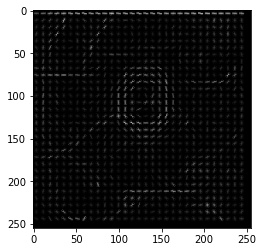

In [7]:
fd, hog_image = hog(clahe_LAB(sample3), orientations=8, pixels_per_cell=(8,8), cells_per_block=(1,1), visualize=True, multichannel=True)
plt.imshow(hog_image, cmap='gray')

In [8]:
fd.shape

(7688,)

In [17]:
train_features_les = [] 
train_features_nv  = []

counter      = 0
start        = 0
stop         = 1000

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = plt.imread(train_data[index]['image'])
    scan_id  = train_data[index]['id']
    label    = train_data[index]['label']
        
    # External Preprocessing
    hr,_     = occlusion_removal(image)       # Occlusion Removal
    cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    
    # Segmentation 
    mask                     = segment_l(cl)
    mask_GL                  = mask.astype(bool)
    img_GL                  = cv2.cvtColor(cl, cv2.COLOR_RGB2GRAY) 
    lesion_GL                = np.multiply(img_GL,mask_GL)    
    compressed_lesion_GL     = np.ma.array(lesion_GL,mask=~mask_GL)
    image                   = cv2.cvtColor(compressed_lesion_GL, cv2.COLOR_GRAY2RGB)
        
    # Feature Extraction
    fd, hog_image = hog(clahe_LAB(image), orientations=8, pixels_per_cell=(8,8), cells_per_block=(1,1), visualize=True, multichannel=True)
    features =fd
    
    # Pass to Feature Vectors
    if (label==1):                           # LES Features
        if (len(train_features_les)==0):
            train_features_les = features
        else:
            train_features_les = np.concatenate((train_features_les,features),axis=0)
    if (label==0):                           # NV Features
        if (len(train_features_nv)==0):
            train_features_nv = features
        else:
            train_features_nv = np.concatenate((train_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Training Set) Complete: "+str(counter))

100%|██████████| 1000/1000 [17:58<00:00,  1.08s/it]

Features Extraction (Training Set) Complete: 1000


In [21]:
val_features_les.shape

NameError: name 'val_features_les' is not defined

In [22]:
val_features_les = [] 
val_features_nv  = []

counter      = 0
start        = 0
stop         = 200

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = plt.imread(val_data[index]['image'])
    scan_id  = val_data[index]['id']
    label    = val_data[index]['label']
    
    # External Preprocessing
    hr,_     = occlusion_removal(image)       # Occlusion Removal
    cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    
    # Segmentation 
    mask                     = segment_l(cl)
    mask_GL                  = mask.astype(bool)
    img_GL                  = cv2.cvtColor(cl, cv2.COLOR_RGB2GRAY) 
    lesion_GL                = np.multiply(img_GL,mask_GL)    
    compressed_lesion_GL     = np.ma.array(lesion_GL,mask=~mask_GL)
    image                   = cv2.cvtColor(compressed_lesion_GL, cv2.COLOR_GRAY2RGB)
        
    # Feature Extraction
    fd, hog_image = hog(clahe_LAB(image), orientations=8, pixels_per_cell=(8,8), cells_per_block=(1,1), visualize=True, multichannel=True)
    features =fd
    
    # Pass to Feature Vectors
    if (label==1):                           # LES Features
        if (len(val_features_les)==0):
            val_features_les = features
        else:
            val_features_les = np.concatenate((val_features_les,features),axis=0)
    if (label==0):                           # NV Features
        if (len(val_features_nv)==0):
            val_features_nv = features
        else:
            val_features_nv = np.concatenate((val_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Validation Set) Complete: "+str(counter))

100%|██████████| 200/200 [03:46<00:00,  1.13s/it]

Features Extraction (Validation Set) Complete: 200


In [23]:
# Generate Randomly Shuffled Consolidated Training and Validation Vectors
X_test, Y_test              = concat_and_shuffled(class0=val_features_nv,   class1=val_features_les,   shuffled=True)
X_train,Y_train             = concat_and_shuffled(class0=train_features_nv, class1=train_features_les, shuffled=True)

# Normalize to Mean=0 and Standard Deviation=1 
X_train                     = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_test                      = (X_test-np.mean(X_test,axis=0))/np.std(X_test,axis=0)

In [24]:
np.nan_to_num(X_train, copy=False, nan=0.0, posinf=None, neginf=None)
np.isfinite(X_train).all()
np.nan_to_num(X_test, copy=False, nan=0.0, posinf=None, neginf=None)
np.isfinite(X_test).all()

True

In [25]:
SVMclassifier = svm.SVC(C=10, kernel='linear', gamma='auto', probability=True, class_weight='balanced', verbose=True, random_state=8)
SVMclassifier.fit(X_train.reshape(-1,1), Y_train)

[LibSVM]

In [ ]:
RFclassifier = RandomForestClassifier(n_estimators=210, max_depth=20, max_features='auto', class_weight='balanced',
                                      min_samples_split=5, min_samples_leaf=1, bootstrap=False, random_state=0)
RFclassifier.fit(X_train.reshape(-1,1), Y_train) 

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=20,
                       min_samples_split=5, n_estimators=210, random_state=0)

In [16]:
feature_limit = 274
RFaccuracy  = accuracy_score(Y_test, RFclassifier.predict(X_test[:,:feature_limit]))
RFprecision = precision_score(Y_test, RFclassifier.predict(X_test[:,:feature_limit]),  average="macro")
RFrecall    = recall_score(Y_test, RFclassifier.predict(X_test[:,:feature_limit]),  average="macro")
RFF1        = f1_score(Y_test, RFclassifier.predict(X_test[:,:feature_limit]),  average="macro")


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
ROC(X_train,Y_train,X_test,Y_test,SVMclassifier, RFclassifier)

In [13]:
feature_limit = 274
# Classification Metrics
SVMaccuracy  = accuracy_score(Y_test, SVMclassifier.predict(X_test[:,:feature_limit]))
SVMprecision = precision_score(Y_test, SVMclassifier.predict(X_test[:,:feature_limit]),  average="macro")
SVMrecall    = recall_score(Y_test, SVMclassifier.predict(X_test[:,:feature_limit]),  average="macro")
SVMF1        = f1_score(Y_test, SVMclassifier.predict(X_test[:,:feature_limit]),  average="macro")

RFaccuracy  = accuracy_score(Y_test, RFclassifier.predict(X_test[:,:feature_limit]))
RFprecision = precision_score(Y_test, RFclassifier.predict(X_test[:,:feature_limit]),  average="macro")
RFrecall    = recall_score(Y_test, RFclassifier.predict(X_test[:,:feature_limit]),  average="macro")
RFF1        = f1_score(Y_test, RFclassifier.predict(X_test[:,:feature_limit]),  average="macro")


outputs = {'SVM':[SVMaccuracy, SVMprecision, SVMrecall, SVMF1],
'RF':[RFaccuracy, RFprecision, RFrecall, RFF1]}

df = pd.DataFrame(outputs,columns=['SVM','RF'], index=['Accuracy','Precesion','Recall','F1'])
print("Super Vector Machine")
print("Accuracy = %0.4f"%SVMaccuracy), print("Precision = %0.4f"%SVMprecision)
print("Recall = %0.4f"%SVMrecall),     print("F1 Score = %0.4f"%SVMF1)
print("---------------------------------")
print("Random Forest")
print("Accuracy = %0.4f"%RFaccuracy),  print("Precision = %0.4f"%RFprecision)
print("Recall = %0.4f"%RFrecall),      
print("F1 Score = %0.4f"%RFF1)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
df
df.to_csv(r'C:\Users\30694\Desktop\outputs\Score_Hog.csv', header=True, index=True)

In [ ]:
# Confusion Matrix
TN1, FP1, FN1, TP1 = confusion_matrix(Y_test, SVMclassifier.predict(X_test[:,:feature_limit])).ravel()
CM1 = confusion_matrix(Y_test, SVMclassifier.predict(X_test[:,:feature_limit]))
CM1 = pd.DataFrame(CM1, index = ["LES (Actual)","NV (Actual)"],
                   columns = ["LES (Predicted)","NV (Predicted)"])

TN2, FP2, FN2, TP2 = confusion_matrix(Y_test, RFclassifier.predict(X_test[:,:feature_limit])).ravel()
CM2 = confusion_matrix(Y_test, RFclassifier.predict(X_test[:,:feature_limit]))
CM2 = pd.DataFrame(CM2, index = ["LES (Actual)","NV (Actual)"],
                   columns = ["LES (Predicted)","NV (Predicted)"])

%matplotlib qt
plt.figure(figsize=[12,4.5])
plt.subplot(121)
sn.heatmap(CM1, annot=True, fmt='g')
plt.subplot(122)
sn.heatmap(CM2, annot=True, fmt='g')
print("Super Vector Machine")
print("TP:{TP} | TN:{TN} | FP:{FP} | FN:{FN}".format(TP=TP1,TN=TN1,FP=FP1,FN=FN1))
print("Sensitivity: {:.3f}".format(TP1/(TP1+FN1)))
print("Specificity: {:.3f}".format(TN1/(TN1+FP1)))
print("---------------------------------")
print("Random Forest")
print("TP:{TP} | TN:{TN} | FP:{FP} | FN:{FN}".format(TP=TP2,TN=TN2,FP=FP2,FN=FN2))
print("Sensitivity: {:.3f}".format(TP2/(TP2+FN2)))
print("Specificity: {:.3f}".format(TN2/(TN2+FP2)))